These are the input parameters for the notebook. They will be automatically changed when the scripts to generate monthly statistics are run. You can modify them manually to generate multiple plots locally as well.

Pass in `None` to remove the filters and plot all data. This is not recommended for production settings, but might be useful for reports based on data snapshots.

In [1]:
year = 2021
month = 10
program = "vail"

In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
from collections import defaultdict
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import emission.core.get_database as edb
import emission.core.wrapper.entry as ecwe
import emission.storage.decorations.analysis_timeseries_queries as esda
import emission.storage.decorations.trip_queries as esdt
import emission.storage.decorations.timeline as esdl
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
from uuid import UUID

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

Connecting to database URL db


In [4]:
import scaffolding
from plots import *

### Collect Data From Database

In [5]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r df_EI
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_re = defaultdict(lambda: 'Other',dic_re)

In [6]:
# hardcoding this to None, None, since these are timeseries plots
tq = scaffolding.get_time_query(None, None)

In [7]:
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)

[UUID('576e37c7-ab7e-4c03-add7-02486bc3f42e'),
 UUID('8b563348-52b3-4e3e-b046-a0aaf4fcea15'),
 UUID('5079bb93-c9cf-46d7-a643-dfc86bb05605'),
 UUID('feabfccd-dd6c-4e8e-8517-9d7177042483'),
 UUID('113aef67-400e-4e21-a29f-d04e50fc42ea'),
 UUID('c8b9fe22-86f8-449a-b64f-c18a8d20eefc'),
 UUID('e7b24d99-324d-4d6d-b247-9edc87d3c848'),
 UUID('1044195f-af9e-43d4-9407-60594e5e9938'),
 UUID('898b1a5e-cdd4-4a0c-90e4-942fa298e456'),
 UUID('1d292b85-c549-409a-a10d-746e957582a0'),
 UUID('cb3222a7-1e72-4a92-8b7b-2c4795402497'),
 UUID('efdbea3b-eef6-48fc-9558-7585f4ad6f24'),
 UUID('960835ac-9d8a-421d-8b8a-bf816f8a4b92'),
 UUID('bd9cffc8-dbf1-402d-a479-f9f148ec9e60'),
 UUID('fc8f71a3-8c82-458d-bf97-18c3ee11a0f3'),
 UUID('f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0'),
 UUID('8b1f3ba4-3de9-45be-a79d-e6a81716ad04'),
 UUID('9606d610-4d24-4960-a77d-9211c5b587ec'),
 UUID('15eb78dd-6e10-4966-ba61-12589c29dc41'),
 UUID('7626d2a0-8f3c-4244-aa97-3ad0f16d5df7')]

Loaded all confirmed trips of length 8335


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,inferred_labels,inferred_trip,expectation,confidence_threshold,expected_trip
0,DwellSegmentationTimeFilter,1.604364e+09,2020-11-02T17:45:22.115000-07:00,"{'type': 'Point', 'coordinates': [-104.9409405...",5fa139609ae96f3a5fcdef31,1.604364e+09,2020-11-02T17:39:08.049000-07:00,"{'type': 'Point', 'coordinates': [-104.9398732...",374.066000,384.730231,...,0,America/Denver,600533265e173ffb99e07625,1d292b85-c549-409a-a10d-746e957582a0,1.604402e+09,NaN,NaN,NaN,NaN,NaN
1,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:12:12-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",5fa4690763a5e0e8d90c7fa4,1.604601e+09,2020-11-05T11:30:56.952000-07:00,"{'type': 'Point', 'coordinates': [-104.9479963...",2475.048000,13765.915676,...,3,America/Denver,600533265e173ffb99e07626,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN
2,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:27:22-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",5fa4690763a5e0e8d90c7fa8,1.604604e+09,2020-11-05T12:22:21.130739-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",300.869261,1508.223413,...,3,America/Denver,600533265e173ffb99e07627,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN
3,DwellSegmentationTimeFilter,1.604606e+09,2020-11-05T12:47:29.017000-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",5fa4690763a5e0e8d90c7faa,1.604605e+09,2020-11-05T12:42:19.793043-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",309.223957,434.038504,...,3,America/Denver,600533265e173ffb99e07628,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN
4,DwellSegmentationTimeFilter,1.604610e+09,2020-11-05T13:54:28.880000-07:00,"{'type': 'Point', 'coordinates': [-105.0824703...",5fa4771a533f6ebf89c7c5e3,1.604610e+09,2020-11-05T13:52:57.667396-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",91.212605,333.230154,...,3,America/Denver,600533265e173ffb99e07629,1d292b85-c549-409a-a10d-746e957582a0,1.604614e+09,NaN,NaN,NaN,NaN,NaN


After filtering, found 8335 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,inferred_labels,inferred_trip,expectation,confidence_threshold,expected_trip
0,DwellSegmentationTimeFilter,1.604364e+09,2020-11-02T17:45:22.115000-07:00,"{'type': 'Point', 'coordinates': [-104.9409405...",5fa139609ae96f3a5fcdef31,1.604364e+09,2020-11-02T17:39:08.049000-07:00,"{'type': 'Point', 'coordinates': [-104.9398732...",374.066000,384.730231,...,0,America/Denver,600533265e173ffb99e07625,1d292b85-c549-409a-a10d-746e957582a0,1.604402e+09,NaN,NaN,NaN,NaN,NaN
1,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:12:12-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",5fa4690763a5e0e8d90c7fa4,1.604601e+09,2020-11-05T11:30:56.952000-07:00,"{'type': 'Point', 'coordinates': [-104.9479963...",2475.048000,13765.915676,...,3,America/Denver,600533265e173ffb99e07626,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN
2,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:27:22-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",5fa4690763a5e0e8d90c7fa8,1.604604e+09,2020-11-05T12:22:21.130739-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",300.869261,1508.223413,...,3,America/Denver,600533265e173ffb99e07627,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN
3,DwellSegmentationTimeFilter,1.604606e+09,2020-11-05T12:47:29.017000-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",5fa4690763a5e0e8d90c7faa,1.604605e+09,2020-11-05T12:42:19.793043-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",309.223957,434.038504,...,3,America/Denver,600533265e173ffb99e07628,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN
4,DwellSegmentationTimeFilter,1.604610e+09,2020-11-05T13:54:28.880000-07:00,"{'type': 'Point', 'coordinates': [-105.0824703...",5fa4771a533f6ebf89c7c5e3,1.604610e+09,2020-11-05T13:52:57.667396-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",91.212605,333.230154,...,3,America/Denver,600533265e173ffb99e07629,1d292b85-c549-409a-a10d-746e957582a0,1.604614e+09,NaN,NaN,NaN,NaN,NaN


In [8]:
labeled_ct = scaffolding.filter_labeled_trips(participant_ct_df)

After filtering, found 6180 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,inferred_labels,inferred_trip,expectation,confidence_threshold,expected_trip
0,DwellSegmentationTimeFilter,1.604364e+09,2020-11-02T17:45:22.115000-07:00,"{'type': 'Point', 'coordinates': [-104.9409405...",5fa139609ae96f3a5fcdef31,1.604364e+09,2020-11-02T17:39:08.049000-07:00,"{'type': 'Point', 'coordinates': [-104.9398732...",374.066000,384.730231,...,0,America/Denver,600533265e173ffb99e07625,1d292b85-c549-409a-a10d-746e957582a0,1.604402e+09,NaN,NaN,NaN,NaN,NaN
1,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:12:12-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",5fa4690763a5e0e8d90c7fa4,1.604601e+09,2020-11-05T11:30:56.952000-07:00,"{'type': 'Point', 'coordinates': [-104.9479963...",2475.048000,13765.915676,...,3,America/Denver,600533265e173ffb99e07626,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN
2,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:27:22-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",5fa4690763a5e0e8d90c7fa8,1.604604e+09,2020-11-05T12:22:21.130739-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",300.869261,1508.223413,...,3,America/Denver,600533265e173ffb99e07627,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN
3,DwellSegmentationTimeFilter,1.604606e+09,2020-11-05T12:47:29.017000-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",5fa4690763a5e0e8d90c7faa,1.604605e+09,2020-11-05T12:42:19.793043-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",309.223957,434.038504,...,3,America/Denver,600533265e173ffb99e07628,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN
4,DwellSegmentationTimeFilter,1.604610e+09,2020-11-05T13:54:28.880000-07:00,"{'type': 'Point', 'coordinates': [-105.0824703...",5fa4771a533f6ebf89c7c5e3,1.604610e+09,2020-11-05T13:52:57.667396-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",91.212605,333.230154,...,3,America/Denver,600533265e173ffb99e07629,1d292b85-c549-409a-a10d-746e957582a0,1.604614e+09,NaN,NaN,NaN,NaN,NaN


In [9]:
expanded_ct = scaffolding.expand_userinputs(labeled_ct)

,mode_confirm,purpose_confirm,replaced_mode
0,walk,meal,same_mode
1,train,personal_med,same_mode
2,skateboard,transit_transfer,bus
3,not_a_trip,transit_transfer,same_mode
4,not_a_trip,transit_transfer,same_mode


After expanding, columns went from 38 -> 41


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,user_id,metadata_write_ts,inferred_labels,inferred_trip,expectation,confidence_threshold,expected_trip,mode_confirm,purpose_confirm,replaced_mode
0,DwellSegmentationTimeFilter,1.604364e+09,2020-11-02T17:45:22.115000-07:00,"{'type': 'Point', 'coordinates': [-104.9409405...",5fa139609ae96f3a5fcdef31,1.604364e+09,2020-11-02T17:39:08.049000-07:00,"{'type': 'Point', 'coordinates': [-104.9398732...",374.066000,384.730231,...,1d292b85-c549-409a-a10d-746e957582a0,1.604402e+09,NaN,NaN,NaN,NaN,NaN,walk,meal,same_mode
1,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:12:12-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",5fa4690763a5e0e8d90c7fa4,1.604601e+09,2020-11-05T11:30:56.952000-07:00,"{'type': 'Point', 'coordinates': [-104.9479963...",2475.048000,13765.915676,...,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN,train,personal_med,same_mode
2,DwellSegmentationTimeFilter,1.604604e+09,2020-11-05T12:27:22-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",5fa4690763a5e0e8d90c7fa8,1.604604e+09,2020-11-05T12:22:21.130739-07:00,"{'type': 'Point', 'coordinates': [-105.0670666...",300.869261,1508.223413,...,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN,skateboard,transit_transfer,bus
3,DwellSegmentationTimeFilter,1.604606e+09,2020-11-05T12:47:29.017000-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",5fa4690763a5e0e8d90c7faa,1.604605e+09,2020-11-05T12:42:19.793043-07:00,"{'type': 'Point', 'coordinates': [-105.080878,...",309.223957,434.038504,...,1d292b85-c549-409a-a10d-746e957582a0,1.604610e+09,NaN,NaN,NaN,NaN,NaN,not_a_trip,transit_transfer,same_mode
4,DwellSegmentationTimeFilter,1.604610e+09,2020-11-05T13:54:28.880000-07:00,"{'type': 'Point', 'coordinates': [-105.0824703...",5fa4771a533f6ebf89c7c5e3,1.604610e+09,2020-11-05T13:52:57.667396-07:00,"{'type': 'Point', 'coordinates': [-105.0827029...",91.212605,333.230154,...,1d292b85-c549-409a-a10d-746e957582a0,1.604614e+09,NaN,NaN,NaN,NaN,NaN,not_a_trip,transit_transfer,same_mode


In [10]:
expanded_ct = scaffolding.data_quality_check(expanded_ct)
expanded_ct.shape

(6129, 41)

In [11]:
# Mapping new labels with dictionaries
expanded_ct['Trip_purpose']= expanded_ct['purpose_confirm'].map(dic_pur)
expanded_ct['Mode_confirm']= expanded_ct['mode_confirm'].map(dic_re)
expanded_ct['Replaced_mode']= expanded_ct['replaced_mode'].map(dic_re)

# Mapping fuel
expanded_ct['Mode_confirm_fuel']= expanded_ct['Mode_confirm'].map(dic_fuel)
expanded_ct['Replaced_mode_fuel']= expanded_ct['Replaced_mode'].map(dic_fuel)

In [12]:
# Change meters to miles
scaffolding.unit_conversions(expanded_ct)

In [13]:
file_suffix = scaffolding.get_file_suffix(year, month, program)
quality_text = scaffolding.get_quality_text(participant_ct_df, expanded_ct)

_2021_10_vail
Based on 6129 confirmed trips from 19 users
of 8335 total trips from 20 users (73.53%)


In [14]:
# Calculate energy impact
expanded_ct = scaffolding.energy_intensity(expanded_ct, df_EI, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.energy_impact_kWH(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.CO2_impact_lb(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')

### Data Preprocessing

In [15]:
# Get timestamp from known year/month/day aggregated to days
data = expanded_ct[['user_id','start_local_dt_year','start_local_dt_month','start_local_dt_day','Mode_confirm','Mode_confirm_EI(kWH)','Mode_confirm_lb_CO2','distance_miles']].copy()
data.rename(columns={'start_local_dt_year':'year','start_local_dt_month':'month','start_local_dt_day':'day'}, inplace=True)
data['date_time'] = pd.to_datetime(data[['year','month','day']])
data = data.drop(columns=['year','month','day'])

# Categorical type will include all days/modes in groupby even if there is no data for a particular tabulation
data.user_id = pd.Categorical(data.user_id)
data.date_time = pd.Categorical(data.date_time)
data.Mode_confirm = pd.Categorical(data.Mode_confirm,
                                   ordered=True,
                                   categories=['Car, drove alone',
                                              'Car, with others',
                                              'Taxi/Uber/Lyft',
                                              'Bus',
                                              'Free Shuttle',
                                              'Train',
                                              'Bikeshare',
                                              'Pilot ebike',
                                              'Regular Bike',
                                              'Scooter share',
                                              'Skate board',
                                              'Walk',
                                              'Other',
                                              'Not a Trip'])

data.head()

,user_id,Mode_confirm,Mode_confirm_EI(kWH),Mode_confirm_lb_CO2,distance_miles,date_time
0,1d292b85-c549-409a-a10d-746e957582a0,Walk,0.000000,0.000000,0.238533,2020-11-02
1,1d292b85-c549-409a-a10d-746e957582a0,Train,3.157901,3.682113,8.534868,2020-11-05
2,1d292b85-c549-409a-a10d-746e957582a0,Skate board,0.000000,0.000000,0.935099,2020-11-05
3,1d292b85-c549-409a-a10d-746e957582a0,Not a Trip,0.000000,0.000000,0.269104,2020-11-05
4,1d292b85-c549-409a-a10d-746e957582a0,Not a Trip,0.000000,0.000000,0.206603,2020-11-05


In [16]:
# Count the number of trips for each confirmed mode
mode_counts = data.groupby(['user_id','date_time','Mode_confirm'], as_index=False).size()
mode_counts.rename(columns={'size':'trip_count'}, inplace=True)

# Sum daily distance traveled for each mode
mode_distance = data.groupby(['user_id','date_time','Mode_confirm'], as_index=False)[['distance_miles']].sum()
mode_distance.rename(columns={'sum':'distance_miles'}, inplace=True)
mode_distance['distance_miles'] = mode_distance['distance_miles'].fillna(0)

# Sum daily emissions for each user
emissions = data.groupby(['user_id','date_time'], as_index=False)[['Mode_confirm_lb_CO2', 'distance_miles']].sum()
emissions['Mode_confirm_lb_CO2'] = emissions['Mode_confirm_lb_CO2'].fillna(0)
emissions['distance_miles'] = emissions['Mode_confirm_lb_CO2'].fillna(0)

# Sum daily energy for each user
energy = data.groupby(['user_id','date_time'], as_index=False)[['Mode_confirm_EI(kWH)', 'distance_miles']].sum()
energy['Mode_confirm_EI(kWH)'] = energy['Mode_confirm_EI(kWH)'].fillna(0)
energy['distance_miles'] = energy['Mode_confirm_EI(kWH)'].fillna(0)

# Get the count of unique users that were active on each given date
active_users = pd.DataFrame(data.groupby(['date_time'], as_index=False)['user_id'].nunique())
active_users.rename(columns={'user_id':'active_users'}, inplace=True)

# Add 7-day rolling avg smoothing to better see trends
mode_counts['trip_count_smooth'] = mode_counts.groupby(['user_id','Mode_confirm'])['trip_count'].apply(lambda x: x.rolling(7,1).mean())
mode_distance['distance_miles_smooth'] = mode_distance.groupby(['user_id','Mode_confirm'])['distance_miles'].apply(lambda x: x.rolling(7,1).mean())
emissions['distance_miles_smooth'] = emissions.groupby(['user_id'])['distance_miles'].apply(lambda x: x.rolling(7,1).mean())
energy['distance_miles_smooth'] = energy.groupby(['user_id'])['distance_miles'].apply(lambda x: x.rolling(7,1).mean())

### Generate Timeseries Plots

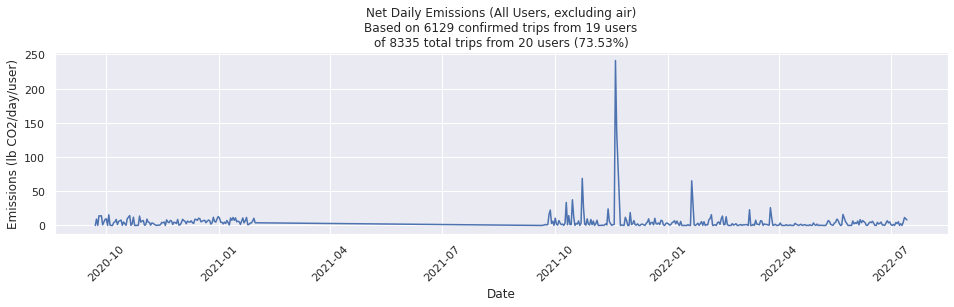

In [17]:
# Emissions per week across all users (net impact)
plot_data = emissions.groupby(['date_time'], as_index=False)['Mode_confirm_lb_CO2'].agg(['sum'])
plot_data = plot_data.merge(active_users, on='date_time')
plot_data['sum'] = plot_data['sum'] / plot_data['active_users']

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='sum').set(title='Net Daily Emissions (All Users, excluding air)\n%s'%quality_text, xlabel='Date', ylabel='Emissions (lb CO2/day/user)')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_emissions_user%s.png" % file_suffix)

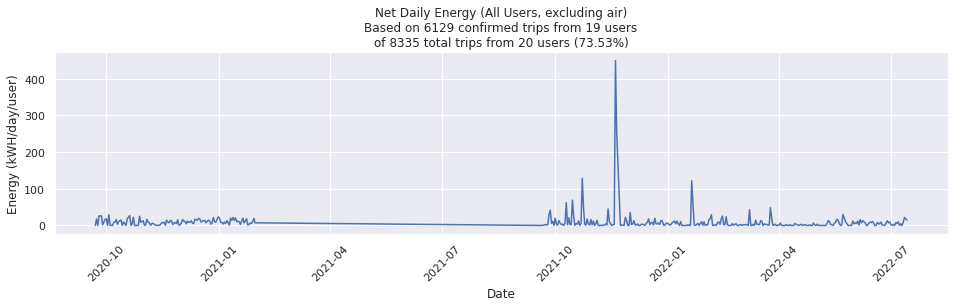

In [20]:
# Energy per week across all users (net impact)
plot_data = energy.groupby(['date_time'], as_index=False)['Mode_confirm_EI(kWH)'].agg(['sum'])
plot_data = plot_data.merge(active_users, on='date_time')
plot_data['sum'] = plot_data['sum'] / plot_data['active_users']

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='sum').set(title='Net Daily Energy (All Users, excluding air)\n%s'%quality_text, xlabel='Date', ylabel='Energy (kWH/day/user)')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_energy_user%s.png" % file_suffix)

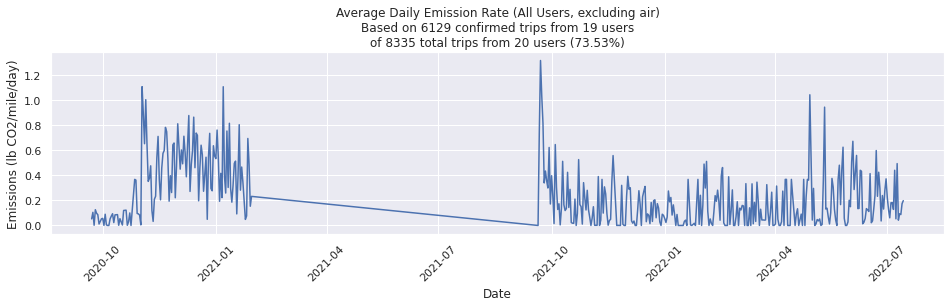

In [21]:
# Emissions per mile per day across all users (travel efficiency)
# Note that the energy plot will be identical to this one since scale factor is divided out
emissions['CO2_per_mile'] = emissions['Mode_confirm_lb_CO2'] / emissions['distance_miles_smooth']
emissions['CO2_per_mile'] = emissions['CO2_per_mile'].fillna(0)
plot_data = emissions.groupby(['date_time'], as_index=False)['CO2_per_mile'].agg(['mean'])

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='mean').set(title='Average Daily Emission Rate (All Users, excluding air)\n%s'%quality_text, xlabel='Date', ylabel='Emissions (lb CO2/mile/day)')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_emissions_vmt%s.png" % file_suffix)

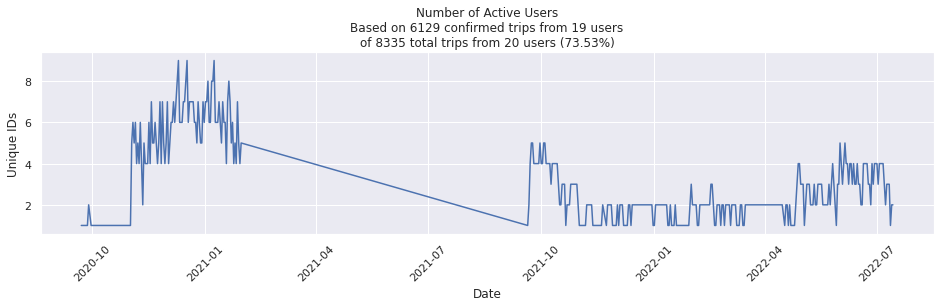

In [23]:
# Plot of active users
plot_data = active_users

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='active_users').set(title='Number of Active Users\n%s'%quality_text, xlabel='Date', ylabel='Unique IDs')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_users%s.png" % file_suffix)

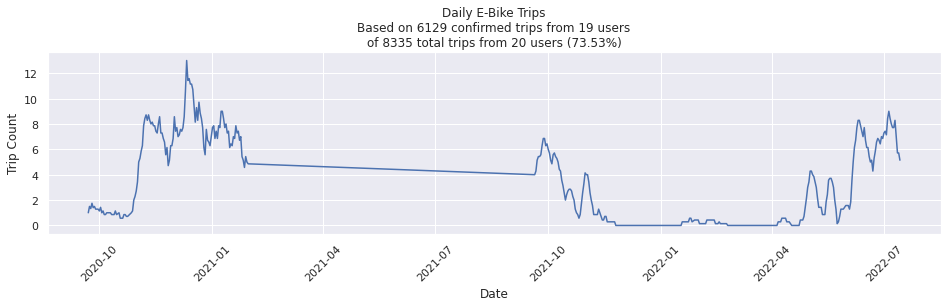

In [24]:
# Plot of total ebikeshare trips across all users
plot_data = mode_counts[mode_counts['Mode_confirm']=='Pilot ebike']
plot_data = plot_data.groupby(['date_time'], as_index=False)['trip_count_smooth'].agg(['sum'])

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='sum').set(title='Daily E-Bike Trips\n%s'%quality_text, xlabel='Date', ylabel='Trip Count')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_ebike_share%s.png" % file_suffix)

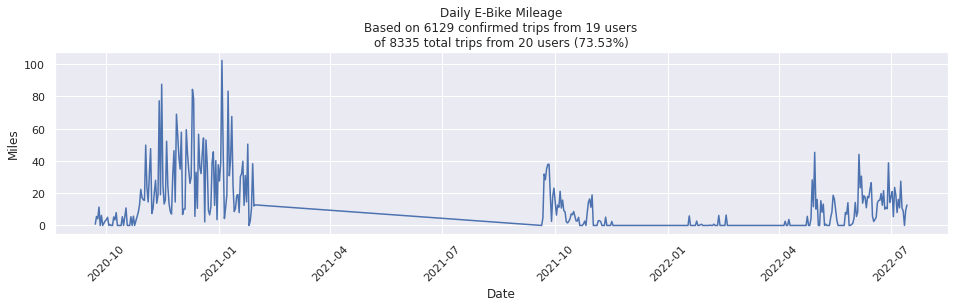

In [25]:
# Plot of total ebikeshare mileage across all users
plot_data = data[data['Mode_confirm']=='Pilot ebike']
plot_data = plot_data.groupby(['date_time'], as_index=False)['distance_miles'].agg(['sum'])

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='sum').set(title='Daily E-Bike Mileage\n%s'%quality_text, xlabel='Date', ylabel='Miles')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_ebike_miles%s.png" % file_suffix)

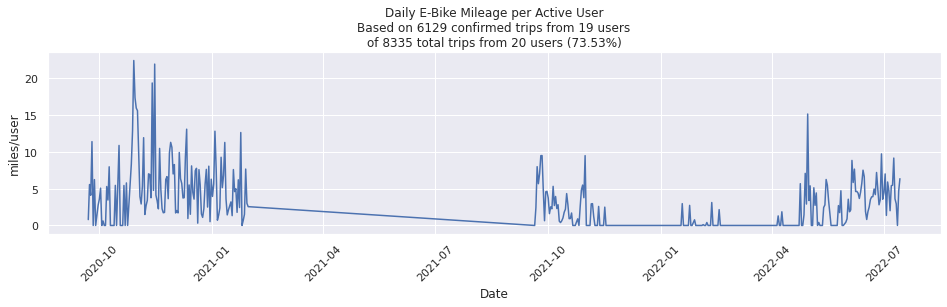

In [26]:
# Plot of total ebikeshare mileage normalized by number of users
plot_data = data[data['Mode_confirm']=='Pilot ebike']
plot_data = plot_data.groupby(['date_time'], as_index=False)['distance_miles'].agg(['sum'])
plot_data = plot_data.merge(active_users, on='date_time')
plot_data['mileage_per_user'] = plot_data['sum'] / plot_data['active_users']

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='mileage_per_user').set(title='Daily E-Bike Mileage per Active User\n%s'%quality_text, xlabel='Date', ylabel='miles/user')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_ebike_miles_user%s.png" % file_suffix)

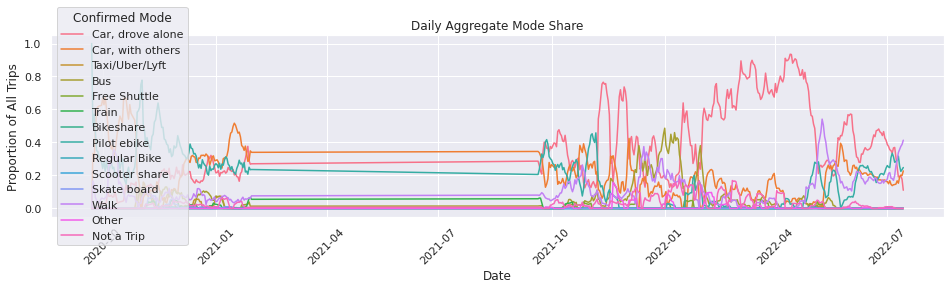

In [27]:
# Plot of mode share proportions across all users
plot_data = mode_counts.groupby(['date_time','Mode_confirm'], as_index=False)['trip_count_smooth'].sum()
total_trips = plot_data.groupby(['date_time'], as_index=False).sum()
plot_data = plot_data.merge(total_trips, on='date_time')
plot_data['trip_proportion'] = plot_data['trip_count_smooth_x'] / plot_data['trip_count_smooth_y']

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='trip_proportion', hue='Mode_confirm').set(title='Daily Aggregate Mode Share', xlabel='Date', ylabel='Proportion of All Trips')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
plt.legend(loc='center left', title='Confirmed Mode')
ax.figure.savefig("/plots/ts_all_modes%s.png" % file_suffix)

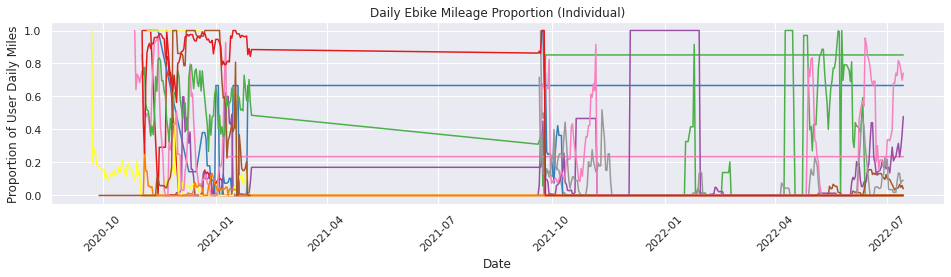

In [28]:
# Plot of ebike mode share across many individual users
# This plot is a little crazy if the number of users displayed is not limited
# For now use the first 20 IDs
test_uuids = pd.unique(mode_distance['user_id'])[:19]
plot_data = mode_distance[mode_distance['user_id'].isin(test_uuids)]
plot_data = plot_data[plot_data['Mode_confirm']=='Pilot ebike']
plot_data = plot_data.groupby(['user_id','date_time'], as_index=False)['distance_miles_smooth'].sum()
total_miles = mode_distance.groupby(['user_id','date_time'], as_index=False)['distance_miles_smooth'].sum()
plot_data = plot_data.merge(total_miles, on=['user_id','date_time'])
plot_data['miles_proportion'] = plot_data['distance_miles_smooth_x'] / plot_data['distance_miles_smooth_y']
plot_data['user_id'] = plot_data['user_id'].astype(str).str[-4:]

fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(ax=ax, data=plot_data, x='date_time', y='miles_proportion', hue='user_id', legend=False, palette="Set1").set(title='Daily Ebike Mileage Proportion (Individual)', xlabel='Date', ylabel='Proportion of User Daily Miles')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig("/plots/ts_ebike_mile_individual%s.png" % file_suffix)